# Bài tập về Sentiment Analysis
Mục tiêu của bài toán Sentiment Analysis (SA) là phân loại được ý kiến bên trong một đoạn văn bản. Ý kiến này có thể chỉ là binary (tốt-xấu) hoặc multi-class (thang điểm từ 1-5).

## Data
Trong bài tập này, chúng ta sử dụng dữ liệu Review được tổng hợp từ Amazon trong một category nhất định. Download nó bằng lệnh `!wget` với đường link như sau:

In [1]:
### Amazon, retrieved from seemingly authentic source: http://jmcauley.ucsd.edu/data/amazon/
#metadata only !wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Amazon_Instant_Video.csv
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz -O /reviews_Digital_Music_5.json.gz

--2024-10-09 14:17:23--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Digital_Music_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32052614 (31M) [application/x-gzip]
Saving to: ‘/reviews_Digital_Music_5.json.gz’

/reviews_Digital_Mu 100%[===================>]  30.57M  25.6MB/s    in 1.2s    

2024-10-09 14:17:24 (25.6 MB/s) - ‘/reviews_Digital_Music_5.json.gz’ saved [32052614/32052614]



Dữ liệu được trả về dưới dạng json.gz, là json nhưng không phải là một file text thông thường. Import thư viện `gzip` (cài nếu không có bằng pip), và sử dụng code bên dưới để load dữ liệu vào một `DataFrame` của pandas.

In [2]:
import pandas as pd
import json, gzip
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

data = pd.DataFrame(parse('/reviews_Digital_Music_5.json.gz'))
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5.0,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5.0,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5.0,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4.0,4.5; music to dream to,1200528000,"01 17, 2008"


## Preprocessing & Vectorizing
Dữ liệu text đang có là một string chưa được phân tích bằng bất cứ thứ gì. Chúng ta không thể bỏ dữ liệu này trực tiếp vào các Vectorizer của sklearn; mà có 2 lựa chọn:
 - Biến đổi trường "reviewText" sang dạng mà Vectorizer có thể tách được bằng hàm `.split` (e.g "Who is that?" -> "Who is that ?")
 - Sử dụng một hàm tự xây dựng, có thể dưới dạng `lambda x: y` có khả năng tách được các text thành các từ token, và đặt hàm này vào argument `tokenizer` của các Vectorizer (e.g "Who is that" -> \["Who", "is", "that", "?"\])

**Học viên cần sử dụng một trong 2 phương pháp trên kết hợp với các phần đã học trên lớp (TF-IDF, n-gram), Vector hóa dữ liệu ra ma trận sparse vào biến `matrix_data`:**

In [3]:
# Example sử dụng nltk
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')

# Define a custom tokenizer function
def custom_tokenizer(text):
    return word_tokenize(text)

# Replace special characters in 'reviewText'
data['reviewText'] = data['reviewText'].str.replace('[^\w\s]', '')

# Initialize the TfidfVectorizer with the custom tokenizer
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 2), max_features=678372)
matrix_data = vectorizer.fit_transform(data['reviewText'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Example sử dụng spacy
# YOUR CODE HERE

In [4]:
matrix_data.shape

(64706, 678372)

## Building Model
Tương tự như đã làm trên lớp, chúng ta cần phải tách dữ liệu ra tập train và test để có thể kiểm soát chất lượng mô hình

**Học viên tách các bộ train và test vào các cặp (features, labels): (`X_train`, `y_train`), (`X_test`, `y_test`) với tỉ lệ 9:1 và random_state 0**

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(matrix_data, data['overall'], test_size=0.1, random_state=0)

Chúng ta sử dụng mô hình Classification phù hợp, có thể là Naive Bayes, SVM hoặc LogisticRegression.

**Học viên tạo mô hình và train cho mô hình đó bằng dữ liệu train:**

In [7]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=5)
model.fit(X_train, y_train)

LogisticRegression(n_jobs=5)

## Evaluation
Đầu tiên, chúng ta sử dụng các metrics và tính qua các giá trị đánh giá thường dùng.

**Tính kết quả của mô hình qua giá trị F1 và accuracy:**

In [9]:
# YOUR CODE HERE
from sklearn.metrics import accuracy_score, f1_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", round(accuracy,4))
print("F1 Score:", round(f1,4))

Accuracy: 0.6557
F1 Score: 0.6163


Với các mô hình classification, chúng ta có thể in ra các giá trị ROC, đại biểu một phần cho chất lượng của classifier bên trong - mô hình với đường cong càng cao, area càng lớn, thì khả năng chọn được một giá trị tốt để phân biệt class đó với các class khác càng cao.

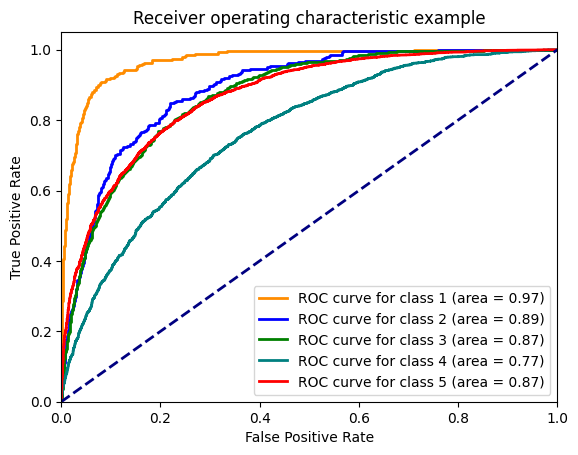

In [10]:
from sklearn.metrics import roc_curve, auc

n_classes = len(model.classes_)
#print(n_classes)
y_score = model.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    class_idx = model.classes_[i]
    fpr[i], tpr[i], _ = roc_curve(y_test == class_idx, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

import matplotlib.pyplot as plt
plt.figure()
lw = 2
for i, color in zip(range(n_classes), ["darkorange", "blue", "green", "teal", "red", "yellow"]):
    class_idx = model.classes_[i]
    plt.plot(fpr[i], tpr[i], color=color,
         lw=lw, label='ROC curve for class %d (area = %0.2f)' % (class_idx, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Một thông tin khác có thể sử dụng là confusion matrix, có thể dùng để visualize kết quả trả ra và lượng lệch của chúng với kết quả chính xác. Code bên dưới in ra confusion matrix với các hàng là nhãn đúng (True label) và các cột là nhãn được đoán ra (Predicted label). VD: hàng 4 cột 1 đại biểu cho bao nhiêu review có nhãn đúng là 4 nhưng mô hình đoán nhãn 1.

**Học viên phát hiện gì khi in ra confusion matrix ở dưới? Vấn đề gọi là gì và xử lý như thế nào?**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


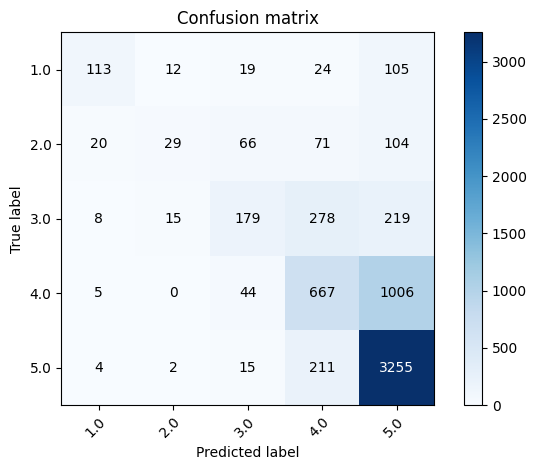

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
# confusion matrix creation
# YOUR CODE HERE
confmx = confusion_matrix(y_test, y_pred)
reg_model = LogisticRegression()
reg_model.fit(X_train, y_train)
classes = reg_model.classes_
cmap = plt.cm.Blues
#print(confmx)
#raise Exception

fig, ax = plt.subplots()
im = ax.imshow(confmx, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(confmx.shape[1]),
       yticks=np.arange(confmx.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title="Confusion matrix",
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = confmx.max() / 2.
for i in range(confmx.shape[0]):
    for j in range(confmx.shape[1]):
        ax.text(j, i, format(confmx[i, j], fmt),
                ha="center", va="center",
                color="white" if confmx[i, j] > thresh else "black")
fig.tight_layout()